In [242]:
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score, fbeta_score, brier_score_loss, recall_score
import pickle as pkl
import warnings

In [243]:
warnings.filterwarnings('ignore')

In [244]:
def avgKS(df1, df2):
  '''Calculates the average Kolmogorov-Smirnov statistic between two dataframes.
  Utilized for EPD generation.
  Args: 
    df1 (pd.Dataframe): First dataframe.
    df2 (pd.Dataframe): Second dataframe.
  Returns: 
    float: Average Kolmogorov-Smirnov statistic.'''
  ksstats = []
  cols = (df1.columns)
  for col in cols:
    cdf1 = (df1[col].sort_values().cumsum())/(len(df1))
    cdf2 = (df2[col].sort_values().cumsum())/(len(df2))
    ksstats.append(np.max(np.abs(cdf1 - cdf2)))
  return np.average(ksstats)

In [245]:
df1 = pd.read_csv('../Data/Edited_bitsM.csv')
df2 = pd.read_csv('../Data/ESIdf.csv')

In [246]:
df1

,Unnamed: 0,Gender,Age,Haemoglobin(gms%),Total WBC Count(/Cumm),Neutrophils(%),Lymphocytes(%),Eosinophils(%),Monocytes(%),Basophils(%),Others,Total RBC Count(millions/Cu),HCT(%),MCV(f L),MCH(pg),MCHC(gms%),RDWCV(%),Platelet Count(Lakh / Cumm),Result
0,0,Male,63.0,11.6,10200,72,23,2,3,0,0,4.20,35.0,84.0,28.3,33.7,14.4,2.20,Negative
1,1,Female,27.0,13.7,7100,63,34,1,2,0,0,4.36,40.1,92.0,31.3,34.1,14.1,2.48,Negative
2,2,Male,63.0,11.1,8500,59,35,3,3,0,0,4.00,33.5,84.0,27.9,33.3,14.0,2.68,Negative
3,3,Male,35.0,14.0,5500,45,50,2,3,0,0,4.73,42.0,89.0,29.7,33.4,14.3,2.34,Negative
4,4,Male,19.0,13.2,5100,61,33,3,3,0,0,3.27,42.2,80.0,25.1,31.4,15.4,1.94,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,331,Male,37.0,14.7,7600,68,21,4,7,0,0,5.06,42.1,83.2,29.1,34.9,12.8,2.11,Positive
332,332,Male,49.0,13.7,8000,68,18,5,9,0,0,4.79,41.0,85.6,28.6,33.4,12.7,2.43,Positive
333,333,Male,49.0,14.7,7000,70,21,3,6,0,0,5.15,44.0,85.4,28.5,33.4,12.8,2.04,Positive
334,334,Male,34.0,14.4,7000,68,25,3,4,0,0,4.63,41.2,89.0,31.1,35.0,12.7,1.47,Positive


In [247]:
#using only 300 negatives, fill with that average
df1 = df1[df1['Result'] != 'Positive']

In [248]:
df = pd.concat([df1, df2], join = 'inner')

In [249]:
df.shape

(375, 19)

In [250]:
encoder = LabelEncoder()
df.drop(columns = [df.columns[0], 'Others'], inplace = True) #Dropping the 'unnamed' column and 'others' column
df['Result'] = encoder.fit_transform(df['Result'])  #Output -> negative = 0, positive = 1
df['Gender'] = encoder.fit_transform(df['Gender']) #Output -> Female = 0, Male = 1

In [251]:
df

,Gender,Age,Haemoglobin(gms%),Total WBC Count(/Cumm),Neutrophils(%),Lymphocytes(%),Eosinophils(%),Monocytes(%),Basophils(%),Total RBC Count(millions/Cu),HCT(%),MCV(f L),MCH(pg),MCHC(gms%),RDWCV(%),Platelet Count(Lakh / Cumm),Result
0,1,63.0,11.6,10200,72,23,2,3,0,4.20,35.0,84.0,28.3,33.7,14.4,2.20,0
1,0,27.0,13.7,7100,63,34,1,2,0,4.36,40.1,92.0,31.3,34.1,14.1,2.48,0
2,1,63.0,11.1,8500,59,35,3,3,0,4.00,33.5,84.0,27.9,33.3,14.0,2.68,0
3,1,35.0,14.0,5500,45,50,2,3,0,4.73,42.0,89.0,29.7,33.4,14.3,2.34,0
4,1,19.0,13.2,5100,61,33,3,3,0,3.27,42.2,80.0,25.1,31.4,15.4,1.94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,71.0,14.0,9100,91,6,0,1,0,5.20,39.3,75.0,26.7,35.6,15.6,1.70,1
71,0,72.0,10.2,11880,81,13,0,3,0,3.40,29.7,85.3,29.3,34.3,12.1,6.00,1
72,1,73.0,12.4,21110,91,6,0,1,0,4.20,35.8,84.8,29.4,34.6,14.6,2.40,1
73,0,75.0,11.3,8400,63,31,2,3,0,3.90,34.0,87.0,28.9,33.2,13.6,3.80,1


In [252]:
# Defining the columns in a particular order
order = ['HCT(%)', 'Haemoglobin(gms%)', 'Platelet Count(Lakh / Cumm)', 'Total RBC Count(millions/Cu)', 
         'Lymphocytes(%)', 'MCHC(gms%)', 'Total WBC Count(/Cumm)', 'Basophils(%)', 'MCH(pg)', 
         'Eosinophils(%)', 'MCV(f L)', 'Monocytes(%)', 'Result']

# Rearranging the columns in the defined order
df = df[order]

# Standardizing the data (z-score normalization, mean = 0, std = 1).
cols = df.columns.tolist()
cols.remove('Result') # Removing the target variable from the list of columns to be standardized

for c in cols: #standardizing the data
    df[c] = ((df[c] - (df[c].mean())))/(df[c].std())

X_test = df.drop(columns = ['Result']) #Indian dataset as test set
Y_test = df['Result']

In [253]:
df

,HCT(%),Haemoglobin(gms%),Platelet Count(Lakh / Cumm),Total RBC Count(millions/Cu),Lymphocytes(%),MCHC(gms%),Total WBC Count(/Cumm),Basophils(%),MCH(pg),Eosinophils(%),MCV(f L),Monocytes(%),Result
0,-0.513971,-0.480113,-0.331979,-0.239918,-0.492923,0.327976,0.574967,-0.05164,0.134979,-0.173565,0.013915,-0.363387,0
1,0.379070,0.524642,-0.032256,0.010453,0.421334,0.514256,-0.313472,-0.05164,1.037244,-0.744503,1.012611,-0.919592,0
2,-0.776630,-0.719341,0.181832,-0.552883,0.504449,0.141697,0.087759,-0.05164,0.014677,0.397373,0.013915,-0.363387,0
3,0.711771,0.668178,-0.182117,0.589437,1.751163,0.188266,-0.772021,-0.05164,0.556036,-0.173565,0.638100,-0.363387,0
4,0.746792,0.285414,-0.610293,-1.695202,0.338220,-0.743131,-0.886659,-0.05164,-0.827437,0.397373,-0.485433,-0.363387,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.238985,0.668178,-0.867198,1.324903,-1.905867,1.212804,0.259715,-0.05164,-0.346229,-1.315441,-1.109618,-1.475796,1
71,-1.442033,-1.149950,3.735689,-1.491775,-1.324067,0.607395,1.056444,-0.05164,0.435734,-1.315441,0.176203,-0.363387,1
72,-0.373886,-0.097350,-0.117891,-0.239918,-1.905867,0.747105,3.701700,-0.05164,0.465809,-1.315441,0.113785,-1.475796,1
73,-0.689077,-0.623650,1.380723,-0.709365,0.171991,0.095127,0.059099,-0.05164,0.315432,-0.173565,0.388426,-0.363387,1


## Creation of Brazilian model


In [254]:
dfBrazil = pd.read_csv('../Data/3-fourteen-feature.csv')

In [255]:
dfBrazil.head()

,Hematocrit,Hemoglobin,Platelets,MPV,Erythrocytes,Lymphocytes,MCHC,Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RDW,CoV-2,Probability
0,-2.085973,-2.032676,-1.235475,2.317897,-2.145106,-0.328111,-0.418941,-0.038206,1.005582,0.625119,-0.558567,0.904244,-0.640155,2.080230,0.0,0.428487
1,-1.274456,-1.352212,2.319303,0.095416,-1.278015,-0.334471,-0.854400,0.794473,-0.576866,-0.092740,-0.114376,0.315128,0.116525,0.530675,1.0,0.911545
2,-0.304165,-0.137099,0.819447,-0.222081,-0.369634,-0.073713,0.713251,-0.135622,0.028762,0.529404,-0.353556,0.172312,0.543436,0.316943,0.0,0.173168
3,-1.045115,-1.011980,2.094915,0.412913,-1.112855,-0.244275,-0.157666,1.427680,-0.576866,0.337975,-0.558567,0.440092,0.535767,0.851272,0.0,0.662734
4,-0.621715,-0.623144,1.716999,0.518746,-0.741245,0.039610,-0.157666,2.158303,-0.576866,0.290118,0.109617,0.422240,1.916198,0.958138,0.0,0.112475


In [256]:
dfBrazil[dfBrazil['CoV-2'] == 1]

,Hematocrit,Hemoglobin,Platelets,MPV,Erythrocytes,Lymphocytes,MCHC,Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RDW,CoV-2,Probability
1,-1.274456,-1.352212,2.319303,0.095416,-1.278015,-0.334471,-0.854400,0.794473,-0.576866,-0.092740,-0.114376,0.315128,0.116525,0.530675,1.0,0.911545
5,-0.939265,-1.206399,1.362702,0.730411,-1.222962,-0.786607,-0.157666,1.984345,-0.576866,0.146546,-0.558567,0.243720,1.762817,0.958138,1.0,0.897204
7,1.160092,1.175224,-1.070137,-0.433746,0.800251,-0.731101,0.364884,-1.084273,-0.010310,0.625119,-0.326981,0.475796,-1.044059,-0.698283,1.0,0.906676
10,0.119234,-0.185703,-0.160775,0.412913,0.538747,-0.131531,-1.289858,-0.764190,-0.381502,-1.528458,-0.558567,-1.059477,-1.118193,0.530675,1.0,0.954391
16,0.401501,0.591970,-1.400814,1.047908,0.414877,0.161606,0.974526,-0.889440,-0.225211,0.290118,0.117210,-0.202581,-0.292491,-0.858581,1.0,0.875864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11881,1.618775,1.612665,-1.117376,-0.010416,1.323258,0.206125,0.364884,-0.499774,-0.225211,0.385832,0.113414,0.208016,-0.425422,-0.110520,1.0,0.802353
11883,-1.045115,-0.914771,-1.282715,2.212064,-0.507268,-0.500408,0.364884,-1.346369,-0.381502,-0.954171,-0.520602,-1.237998,-1.266462,0.316943,1.0,0.908100
11888,-0.286524,-0.477330,-0.833939,1.471237,-0.314581,-0.673862,-0.941491,-1.107467,-0.381502,-0.379884,-0.106783,0.065200,-0.880452,-0.537984,1.0,0.910985
11893,-0.304165,-0.428726,-0.975658,-0.327913,-0.135657,-0.841533,-0.680216,-0.729399,-0.576866,-0.667027,-0.167527,-0.416805,-0.496999,-0.644850,1.0,0.819192


In [257]:
#Drop MPV, Probability
dfBrazil = dfBrazil.drop(columns = ['MPV', 'Probability'])
dfBrazil

,Hematocrit,Hemoglobin,Platelets,Erythrocytes,Lymphocytes,MCHC,Leukocytes,Basophils,MCH,Eosinophils,MCV,Monocytes,RDW,CoV-2
0,-2.085973,-2.032676,-1.235475,-2.145106,-0.328111,-0.418941,-0.038206,1.005582,0.625119,-0.558567,0.904244,-0.640155,2.080230,0.0
1,-1.274456,-1.352212,2.319303,-1.278015,-0.334471,-0.854400,0.794473,-0.576866,-0.092740,-0.114376,0.315128,0.116525,0.530675,1.0
2,-0.304165,-0.137099,0.819447,-0.369634,-0.073713,0.713251,-0.135622,0.028762,0.529404,-0.353556,0.172312,0.543436,0.316943,0.0
3,-1.045115,-1.011980,2.094915,-1.112855,-0.244275,-0.157666,1.427680,-0.576866,0.337975,-0.558567,0.440092,0.535767,0.851272,0.0
4,-0.621715,-0.623144,1.716999,-0.741245,0.039610,-0.157666,2.158303,-0.576866,0.290118,0.109617,0.422240,1.916198,0.958138,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,0.789617,0.591970,-0.196204,0.249717,0.844434,-0.593125,0.439599,0.419490,0.625119,0.291849,1.029209,0.142089,-0.377685,0.0
11912,0.383859,0.397552,-0.373353,0.222190,-0.540881,0.190701,0.425682,0.419490,0.290118,-0.137155,0.225868,0.234118,-0.965447,0.0
11913,0.260368,0.446156,-0.326113,0.139610,-0.184145,0.887434,-0.379163,0.458563,0.577261,0.121007,0.154460,-0.098208,-0.484551,1.0
11914,0.172159,0.591970,-1.070137,-0.576084,-0.152345,1.932534,1.796470,-0.576866,2.778695,-0.558567,1.921809,-0.448429,-0.751715,0.0


In [258]:
# Renaming columns to match the Indian dataset
dfBrazil = dfBrazil.rename(columns = {'Hematocrit' : 'HCT(%)', 
                                      'Hemoglobin' : 'Haemoglobin(gms%)',
                                      'Platelets' : 'Platelet Count(Lakh / Cumm)',
                                      'Erythrocytes' : 'Total RBC Count(millions/Cu)',
                                      'Lymphocytes' : 'Lymphocytes(%)',
                                      'MCHC' : 'MCHC(gms%)',
                                      'Leukocytes' : 'Total WBC Count(/Cumm)',
                                      'Basophils' : 'Basophils(%)',
                                      'MCH' : 'MCH(pg)',
                                      'Eosinophils' : 'Eosinophils(%)',
                                      'MCV' : 'MCV(f L)',
                                      'Monocytes' : 'Monocytes(%)',
                                      'RDW' : 'RDWCV(%)',
                                      'CoV-2' : 'Result'})

In [ ]:
dfBrazil.columns

# Total RBC count is not present in Italian dataset, so we have removed it to maintain consistency

Index(['HCT(%)', 'Haemoglobin(gms%)', 'Platelet Count(Lakh / Cumm)',
       'Total RBC Count(millions/Cu)', 'Lymphocytes(%)', 'MCHC(gms%)',
       'Total WBC Count(/Cumm)', 'Basophils(%)', 'MCH(pg)', 'Eosinophils(%)',
       'MCV(f L)', 'Monocytes(%)', 'RDWCV(%)', 'Result'],
      dtype='object')

In [263]:
dfBrazil.drop(columns = ['RDWCV(%)', 'Total RBC Count(millions/Cu)'], inplace=True)

In [264]:
dfBrazil

,HCT(%),Haemoglobin(gms%),Platelet Count(Lakh / Cumm),Lymphocytes(%),MCHC(gms%),Total WBC Count(/Cumm),Basophils(%),MCH(pg),Eosinophils(%),MCV(f L),Monocytes(%),Result
0,-2.085973,-2.032676,-1.235475,-0.328111,-0.418941,-0.038206,1.005582,0.625119,-0.558567,0.904244,-0.640155,0.0
1,-1.274456,-1.352212,2.319303,-0.334471,-0.854400,0.794473,-0.576866,-0.092740,-0.114376,0.315128,0.116525,1.0
2,-0.304165,-0.137099,0.819447,-0.073713,0.713251,-0.135622,0.028762,0.529404,-0.353556,0.172312,0.543436,0.0
3,-1.045115,-1.011980,2.094915,-0.244275,-0.157666,1.427680,-0.576866,0.337975,-0.558567,0.440092,0.535767,0.0
4,-0.621715,-0.623144,1.716999,0.039610,-0.157666,2.158303,-0.576866,0.290118,0.109617,0.422240,1.916198,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11911,0.789617,0.591970,-0.196204,0.844434,-0.593125,0.439599,0.419490,0.625119,0.291849,1.029209,0.142089,0.0
11912,0.383859,0.397552,-0.373353,-0.540881,0.190701,0.425682,0.419490,0.290118,-0.137155,0.225868,0.234118,0.0
11913,0.260368,0.446156,-0.326113,-0.184145,0.887434,-0.379163,0.458563,0.577261,0.121007,0.154460,-0.098208,1.0
11914,0.172159,0.591970,-1.070137,-0.152345,1.932534,1.796470,-0.576866,2.778695,-0.558567,1.921809,-0.448429,0.0


In [266]:
scores = []

In [267]:
#Checking for null values
dfBrazil.isnull().sum()

#check null values for each column 
for col in dfBrazil.columns:
    print(f"{col} : {dfBrazil[col].isnull().sum()}")

HCT(%) : 0
Haemoglobin(gms%) : 0
Platelet Count(Lakh / Cumm) : 0
Lymphocytes(%) : 0
MCHC(gms%) : 0
Total WBC Count(/Cumm) : 0
Basophils(%) : 0
MCH(pg) : 0
Eosinophils(%) : 0
MCV(f L) : 0
Monocytes(%) : 0
Result : 0


## Model without splitting

In [268]:
internal_model = XGBClassifier()
internal_model.fit(dfBrazil.drop(columns = ['Result']), dfBrazil['Result'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [269]:
##Save the model in a pickle file

#Don't create a new file if one already exists
try:
    with open('../Models/brazil_model.pkl', 'rb') as f:
        internal_model = pkl.load(f)
except FileNotFoundError:
    with open('../Models/brazil_model.pkl', 'wb') as f:
        pkl.dump(internal_model, f)


## 375 dataset


In [270]:
X_test = X_test.drop(columns = ['Total RBC Count(millions/Cu)'] )

Accuracy: 0.7066666666666667
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       300
           1       0.19      0.15      0.17        75

    accuracy                           0.71       375
   macro avg       0.50      0.50      0.49       375
weighted avg       0.68      0.71      0.69       375

sensitivity 0.14666666666666667
specificity 0.8466666666666667
balanced_accuracy 0.4966666666666667
f2_score 0.18151815181518152
roc_auc_score 0.4966666666666667
brierscore 0.20504474862109934


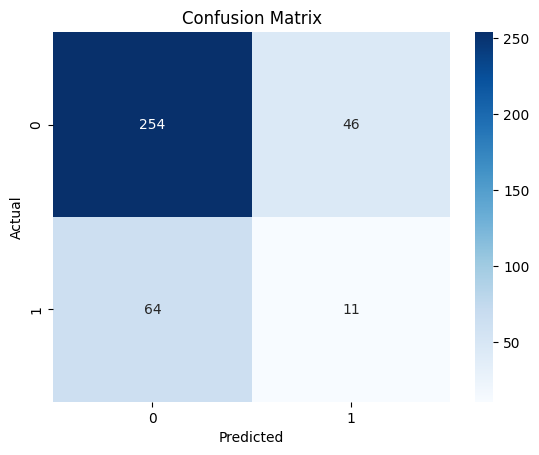

,Model,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F2 Score,ROC AUC,Brier Score
0,Brazil on India 375,0.146667,0.846667,0.706667,0.496667,0.181518,0.496667,0.205045


In [271]:
binary_predictions = internal_model.predict(X_test)
accuracy = accuracy_score(Y_test, binary_predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(Y_test, binary_predictions))
cm = confusion_matrix(Y_test, binary_predictions)
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
balanced_accuracy = balanced_accuracy_score(Y_test, binary_predictions)
f2_score = fbeta_score(Y_test, binary_predictions, beta = 0.5)
print('sensitivity', sensitivity)
print('specificity', specificity)
print('balanced_accuracy', balanced_accuracy)
print('f2_score', f2_score)
roc_auc = roc_auc_score(Y_test, binary_predictions)
print('roc_auc_score', roc_auc_score(Y_test, binary_predictions))
y_proba = internal_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(Y_test, y_proba)
print('brierscore', brier_score_loss(Y_test, y_proba))
sns.heatmap(cm, annot = True, fmt = "d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")    
plt.show()

metrics_df = pd.DataFrame({
    'Model' : 'Brazil on India 375',
    'Sensitivity': [sensitivity],
    'Specificity': [specificity],
    'Accuracy' : [accuracy],
    'Balanced Accuracy': [balanced_accuracy],
    'F2 Score': [f2_score],
    'ROC AUC': [roc_auc],
    'Brier Score': [brier_score]
})
display(metrics_df)


In [272]:
# Similarity score

sim_score375 = avgKS(X_test, dfBrazil)

In [273]:
out1 = pd.DataFrame()
out1['y_true'] = Y_test.copy()
out1['y_proba'] = ((internal_model.predict_proba(X_test))[:, 1])
out1.to_csv('../Results/1aIndiaBrazil375.csv', index = False)

In [274]:
def computemetrics(y_true, y_proba):
    thresh = [0.15, 0.5]
    prop = np.mean(y_true == 1)  # prevalence
    auc = roc_auc_score(y_true, y_proba)
    for th in thresh:
        y_pred = (y_proba >= th).astype(int)
        tpr = recall_score(y_true, y_pred)  # sensitivity
        tnr = recall_score(y_true, y_pred, pos_label=0)  # specificity
        std_net_benefit = ((tpr * prop - (1 - tnr) * (1 - prop) * th / (1 - th)) / prop)
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        print(
            f"Threshold - {th} Standardized Net Benefit - {round(std_net_benefit, 3)}",
            f"AUC Score - {round(auc, 3)}",
            f"Balanced Accuracy - {round(bal_acc, 3)}"
        )

In [275]:
computemetrics(Y_test, y_proba)

Threshold - 0.15 Standardized Net Benefit - 0.198 AUC Score - 0.547 Balanced Accuracy - 0.532
Threshold - 0.5 Standardized Net Benefit - -0.467 AUC Score - 0.547 Balanced Accuracy - 0.497


## Smote Indian Dataset (600)

In [276]:
df = pd.read_csv('../Data/smoteesimedc.csv')

In [277]:
df.drop(columns = [df.columns[0], 'Gender', 'Age'])

,Haemoglobin(gms%),Total WBC Count(/Cumm),Neutrophils(%),Lymphocytes(%),Eosinophils(%),Monocytes(%),Basophils(%),Total RBC Count(millions/Cu),HCT(%),MCV(f L),MCH(pg),MCHC(gms%),RDWCV(%),Platelet Count(Lakh / Cumm),Result
0,11.6,10200,72,23,2,3,0,4.20,35.00,84.00,28.30,33.70,14.40,2.20,0
1,13.7,7100,63,34,1,2,0,4.36,40.10,92.00,31.30,34.10,14.10,2.48,0
2,11.1,8500,59,35,3,3,0,4.00,33.50,84.00,27.90,33.30,14.00,2.68,0
3,14.0,5500,45,50,2,3,0,4.73,42.00,89.00,29.70,33.40,14.30,2.34,0
4,13.2,5100,61,33,3,3,0,3.27,42.20,80.00,25.10,31.40,15.40,1.94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,12.9,12577,84,12,0,2,0,4.38,37.64,84.69,29.01,34.30,14.69,1.11,1
596,9.9,16759,90,6,0,2,0,3.79,30.04,78.92,25.93,32.89,17.51,4.53,1
597,10.5,14470,77,12,1,7,0,3.57,32.81,89.67,28.80,32.10,13.55,4.04,1
598,11.4,17961,78,18,0,1,0,3.72,33.82,91.13,30.10,33.13,13.75,2.48,1


In [278]:
order = ['HCT(%)', 'Haemoglobin(gms%)', 'Platelet Count(Lakh / Cumm)', 'Total RBC Count(millions/Cu)', 'Lymphocytes(%)', 'MCHC(gms%)', 'Total WBC Count(/Cumm)', 'Basophils(%)', 'MCH(pg)', 'Eosinophils(%)', 'MCV(f L)', 'Monocytes(%)', 'RDWCV(%)', 'Result']
df = df.reindex(columns=dfBrazil.columns)
# df = df[order]
cols = df.columns.tolist()
cols.remove('Result')
for c in cols:
    df[c] = ((df[c] - (df[c].mean())))/(df[c].std())
X_test = df.drop(columns = ['Result'])
Y_test = df['Result']

In [279]:
X_test

,HCT(%),Haemoglobin(gms%),Platelet Count(Lakh / Cumm),Lymphocytes(%),MCHC(gms%),Total WBC Count(/Cumm),Basophils(%),MCH(pg),Eosinophils(%),MCV(f L),Monocytes(%)
0,-0.506283,-0.504099,-0.369887,-0.179127,0.213477,0.232943,-0.040825,0.074266,0.170456,0.000298,-0.242034
1,0.360824,0.444900,-0.075519,0.675709,0.410464,-0.536994,-0.040825,1.032127,-0.356728,1.067662,-0.813769
2,-0.761314,-0.730052,0.134743,0.753421,0.016489,-0.189281,-0.040825,-0.053449,0.697640,0.000298,-0.242034
3,0.683864,0.580471,-0.222703,1.919106,0.065736,-0.934382,-0.040825,0.521268,0.170456,0.667400,-0.242034
4,0.717868,0.218948,-0.643228,0.597996,-0.919199,-1.033729,-0.040825,-0.947452,0.697640,-0.533384,-0.242034
...,...,...,...,...,...,...,...,...,...,...,...
595,-0.057427,0.083376,-1.515818,-1.033963,0.508957,0.823312,-0.040825,0.300960,-0.883912,0.092358,-0.813769
596,-1.349586,-1.272337,2.079672,-1.500237,-0.185422,1.861983,-0.040825,-0.682444,-0.883912,-0.677478,-0.813769
597,-0.878628,-1.001194,1.564528,-1.033963,-0.574472,1.293471,-0.040825,0.233910,-0.356728,0.756792,2.044905
598,-0.706907,-0.594480,-0.075519,-0.567689,-0.067230,2.160520,-0.040825,0.648982,-0.883912,0.951586,-1.385504


Accuracy: 0.5183333333333333
              precision    recall  f1-score   support

           0       0.51      0.86      0.64       300
           1       0.56      0.18      0.27       300

    accuracy                           0.52       600
   macro avg       0.53      0.52      0.45       600
weighted avg       0.53      0.52      0.45       600

sensitivity 0.17666666666666667
specificity 0.86
balanced_accuracy 0.5183333333333333
f2_score 0.38970588235294124
roc_auc_score 0.5183333333333333
brierscore 0.3498039713894438


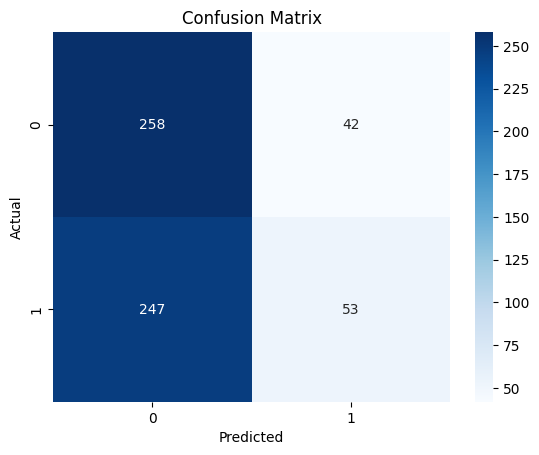

,Model,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F2 Score,ROC AUC,Brier Score
0,Brazil on India Smote,0.176667,0.86,0.518333,0.518333,0.389706,0.518333,0.349804


Index(['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'Balanced Accuracy',
       'F2 Score', 'ROC AUC', 'Brier Score'],
      dtype='object')
Index(['Model', 'Sensitivity', 'Specificity', 'Accuracy', 'Balanced Accuracy',
       'F2 Score', 'ROC AUC', 'Brier Score'],
      dtype='object')


,Model,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F2 Score,ROC AUC,Brier Score
0,Brazil on India 375,0.146667,0.846667,0.706667,0.496667,0.181518,0.496667,0.205045
0,Brazil on India Smote,0.176667,0.860000,0.518333,0.518333,0.389706,0.518333,0.349804


In [280]:
binary_predictions = internal_model.predict(X_test)
accuracy = accuracy_score(Y_test, binary_predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(Y_test, binary_predictions))
cm = confusion_matrix(Y_test, binary_predictions)
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
balanced_accuracy = balanced_accuracy_score(Y_test, binary_predictions)
f2_score = fbeta_score(Y_test, binary_predictions, beta = 0.5)
print('sensitivity', sensitivity)
print('specificity', specificity)
print('balanced_accuracy', balanced_accuracy)
print('f2_score', f2_score)
roc_auc = roc_auc_score(Y_test, binary_predictions)
print('roc_auc_score', roc_auc_score(Y_test, binary_predictions))
y_proba = internal_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(Y_test, y_proba)
print('brierscore', brier_score_loss(Y_test, y_proba))
sns.heatmap(cm, annot = True, fmt = "d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")    
plt.show()

metrics_df2 = pd.DataFrame({
    'Model' : 'Brazil on India Smote',
    'Sensitivity': [sensitivity],
    'Specificity': [specificity],
    'Accuracy' : [accuracy],
    'Balanced Accuracy': [balanced_accuracy],
    'F2 Score': [f2_score],
    'ROC AUC': [roc_auc],
    'Brier Score': [brier_score]
})
display(metrics_df2)
print(metrics_df.columns)
print(metrics_df2.columns)

metrics_df = pd.concat([metrics_df, metrics_df2])
metrics_df


In [281]:
sim_score600B = avgKS(df, dfBrazil)

In [282]:
computemetrics(Y_test, y_proba)

Threshold - 0.15 Standardized Net Benefit - 0.498 AUC Score - 0.59 Balanced Accuracy - 0.588
Threshold - 0.5 Standardized Net Benefit - 0.037 AUC Score - 0.59 Balanced Accuracy - 0.518


In [283]:
out2 = pd.DataFrame()
out2['y_true'] = Y_test.copy()
out2['y_proba'] = ((internal_model.predict_proba(X_test))[:, 1])
out2.to_csv('../Data/1bIndiaBrazil600.csv', index = False)

## Italy


In [284]:
dfItaly = pd.read_csv('../Data/Dataset-2a.csv')

In [285]:
dfItaly.drop(columns = ['Sex', 'Age', 'Calcium', 'Creatine_kinase', 
                        'Creatinine', 'Alkaline_phosphatase','Gamma_glutamyltransferase', 'Glucose',
                            	'Aspartate_aminotransferase', 'Alanine_aminotransferase', 'Lactate_dehydrogenase',
                        'Urea', 'Covid-specific_symptoms', 'Erythrocytes_(10^12/L)', 'Neutrophils_(10^9/L)',
                        'Lymphocytes_(10^9/L)',	'Monocytes_(10^9/L)',	
                        'Eosinophils_(10^9/L)',	'Basophils_(10^9/L)'], inplace=True)

In [286]:
# #Preprocessing

dfItaly.rename(columns = {'CoV-2' : 'Result', 'Leukocytes_(10^9/L)' : 'Total WBC Count(/Cumm)', 
                          'Platelets_(10^9/L)' : 'Platelet Count(Lakh / Cumm)', 'MCHC' : 'MCHC(gms%)',
                          'Hemoglobin' : 'Haemoglobin(gms%)', 'MCV' : 'MCV(f L)',
                          'Eosinophils_(%)' : 'Eosinophils(%)', 'Lymphocytes_(%)' : 'Lymphocytes(%)',
                          'Neutrophils_(%)' : 'Neutrophils(%)',
                          'Basophils_(%)' : 'Basophils(%)', 'Hematocrit' : 'HCT(%)', 'MCH' : 'MCH(pg)',
                          'Monocytes_(%)' : 'Monocytes(%)'}, inplace=True)

In [287]:
dfItaly.drop(columns = ['Neutrophils(%)'], inplace=True)

In [288]:
dfItaly = dfItaly.reindex(columns = dfBrazil.columns)

In [289]:
dfItaly

,HCT(%),Haemoglobin(gms%),Platelet Count(Lakh / Cumm),Lymphocytes(%),MCHC(gms%),Total WBC Count(/Cumm),Basophils(%),MCH(pg),Eosinophils(%),MCV(f L),Monocytes(%),Result
0,-0.143897,0.034744,-0.357794,-0.470825,0.720550,0.276856,0.591746,2.031963,1.245906,1.950285,0.429497,0
1,0.601112,0.838773,1.068793,NaN,1.055218,0.129722,NaN,-0.243222,NaN,-0.770177,NaN,1
2,0.361645,0.424576,-0.363020,-0.670739,0.385882,-0.395755,-0.883555,-0.224572,-0.359497,-0.438237,-0.137165,0
3,0.530159,0.643857,-0.263734,1.628280,0.608994,0.234818,2.067046,-0.094029,0.504951,-0.394941,0.429497,0
4,-1.899991,-1.922540,-1.874959,2.309807,-0.878421,-1.593844,0.591746,0.937885,4.703700,1.601508,0.558283,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1383,-1.958274,-1.917899,0.305856,-0.531837,-0.570313,0.519777,-0.040526,-0.189939,1.625205,0.081320,0.124088,0
1384,-1.758084,-1.597680,0.483527,0.028962,0.162770,-0.582825,-0.514730,-0.243222,0.813682,-0.337212,-0.162923,1
1385,0.873100,0.984961,-0.324699,0.510575,0.658574,-0.442698,1.452338,1.472491,1.842787,1.351351,0.558283,1
1386,1.966963,1.862084,-0.049484,-0.452650,0.162770,0.550104,0.222920,1.248703,0.134473,1.336918,0.017379,0


In [290]:
X_test = dfItaly.drop(columns = ['Result'])
Y_test = dfItaly['Result']

Accuracy: 0.6188760806916427
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       623
           1       0.79      0.42      0.55       765

    accuracy                           0.62      1388
   macro avg       0.67      0.64      0.61      1388
weighted avg       0.68      0.62      0.60      1388

sensitivity 0.42091503267973857
specificity 0.8619582664526485
balanced_accuracy 0.6414366495661935
f2_score 0.6716729244889444
roc_auc_score 0.6414366495661935
brierscore 0.2605174121817328


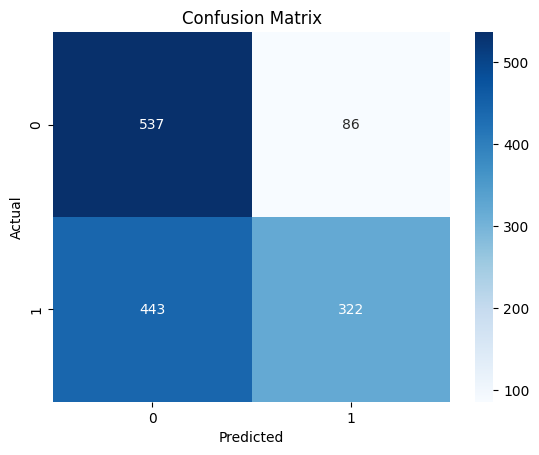

,Model,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F2 Score,ROC AUC,Brier Score
0,Brazil on India 375,0.146667,0.846667,0.706667,0.496667,0.181518,0.496667,0.205045
0,Brazil on India Smote,0.176667,0.860000,0.518333,0.518333,0.389706,0.518333,0.349804
2,Brazil on Italy,0.420915,0.861958,0.618876,0.641437,0.671673,0.641437,0.260517


In [291]:
binary_predictions = internal_model.predict(X_test)
accuracy = accuracy_score(Y_test, binary_predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(Y_test, binary_predictions))
cm = confusion_matrix(Y_test, binary_predictions)
sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
balanced_accuracy = balanced_accuracy_score(Y_test, binary_predictions)
f2_score = fbeta_score(Y_test, binary_predictions, beta = 0.5)
print('sensitivity', sensitivity)
print('specificity', specificity)
print('balanced_accuracy', balanced_accuracy)
print('f2_score', f2_score)
roc_auc = roc_auc_score(Y_test, binary_predictions)
print('roc_auc_score', roc_auc_score(Y_test, binary_predictions))
y_proba = internal_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(Y_test, y_proba)
print('brierscore', brier_score_loss(Y_test, y_proba))
sns.heatmap(cm, annot = True, fmt = "d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")    
plt.show()

new_metrics = {
    'Model' : 'Brazil on Italy',
    'Sensitivity': sensitivity,  
    'Specificity': specificity,  
    'Accuracy' : accuracy,
    'Balanced Accuracy': balanced_accuracy,  
    'F2 Score': f2_score,  
    'ROC AUC': roc_auc,  
    'Brier Score': brier_score 
}

metrics_df.loc[len(metrics_df)] = new_metrics
display(metrics_df)


In [292]:
computemetrics(Y_test, y_proba)

Threshold - 0.15 Standardized Net Benefit - 0.721 AUC Score - 0.746 Balanced Accuracy - 0.669
Threshold - 0.5 Standardized Net Benefit - 0.308 AUC Score - 0.746 Balanced Accuracy - 0.641


In [293]:
sim_scoreBItaly = avgKS(X_test, dfBrazil)

In [294]:
out3 = pd.DataFrame()
out3['y_true'] = Y_test.copy()
out3['y_proba'] = ((internal_model.predict_proba(X_test))[:, 1])
out3.to_csv('../Results/1cItalyBrazil.csv', index = False)

In [295]:
metrics_df.to_csv('../Results/Brazil_metrics.csv', index = False)

In [296]:
br = pd.read_csv('../Results/Brazil_metrics.csv')
it = pd.read_csv('../Results/Italy_metrics.csv')

brit = pd.concat([br, it])

brit.to_csv('../Results/merged_brit.csv')
brit

,Model,Sensitivity,Specificity,Accuracy,Balanced Accuracy,F2 Score,ROC AUC,Brier Score
0,Brazil on India 375,0.146667,0.846667,0.706667,0.496667,0.181518,0.496667,0.205045
1,Brazil on India Smote,0.176667,0.860000,0.518333,0.518333,0.389706,0.518333,0.349804
2,Brazil on Italy,0.420915,0.861958,0.618876,0.641437,0.671673,0.641437,0.260517
0,Italy on Indian 375,0.440000,0.513333,0.498667,0.476667,0.208597,0.476667,0.363717
1,Italy on Indian 600,0.516667,0.570000,0.543333,0.543333,0.539694,0.543333,0.334481
2,Italy on Brazil,0.727186,0.620910,0.648959,0.674048,0.446802,0.543333,0.334481


## For EPD

In [297]:
df_similarity_Brazil = pd.DataFrame([sim_score375, sim_score600B, sim_scoreBItaly])

In [298]:
df_similarity_Brazil.to_csv('../Results/SimilarityBrazil.csv', index = False)